# Titanic in space

[Kaggle](https://www.kaggle.com/competitions/spaceship-titanic/)


## Data 
## File and Data Field Descriptions
train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.

`PassengerId` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
`HomePlanet` - The planet the passenger departed from, typically their planet of permanent residence.

`CryoSleep` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

`Cabin` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

`Destination` - The planet the passenger will be debarking to.

`Age` - The age of the passenger.

`VIP` - Whether the passenger has paid for special VIP service during the voyage.

`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

`Name` - The first and last names of the passenger.

`Transported` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
sample_submission.csv - A submission file in the correct format.
`PassengerId` - Id for each passenger in the test set.
`Transported` - The target. For each passenger, predict either True or False.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels as sm


pd.set_option('display.max_columns', None)

C:\Users\vetle\AppData\Local\Temp\ipykernel_2552\4151701284.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('train.csv')

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
df.shape

(8693, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# Helper functions

# Making new features 
def passenger_group(df):
    df_out = df.copy()
    df_out['PassengerGroup'] = df_out.PassengerId.str.split('_').str[0].astype(float)
    df_out['PassengerInternalGroupNumber'] = df_out.PassengerId.str.split('_').str[1].astype(float)
    return df_out

def cabin_split(df):
    df_out = df.copy()
    df_out['Deck'] = df_out.Cabin.str.split('/').str[0]
    df_out['Num'] = df_out.Cabin.str.split('/').str[1].astype(float)
    df_out['Side'] = df_out.Cabin.str.split('/').str[2]
    return df_out

In [6]:
df_in_use = df.copy()
df_in_use = passenger_group(df_in_use)
df_in_use = cabin_split(df_in_use)

df_in_use.sample(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerInternalGroupNumber,Deck,Num,Side
2952,3200_01,Earth,False,F/669/P,TRAPPIST-1e,40.0,False,4.0,11.0,669.0,0.0,773.0,Brie Flynney,False,3200.0,1.0,F,669.0,P
3024,3279_01,Europa,False,C/123/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,Mard Whifounrew,True,3279.0,1.0,C,123.0,S
6011,6363_02,NaN,True,G/1026/P,55 Cancri e,3.0,False,0.0,0.0,0.0,0.0,0.0,Dwindy Gouldensen,True,6363.0,2.0,G,1026.0,P
262,0288_01,Earth,False,F/55/S,55 Cancri e,19.0,False,0.0,0.0,0.0,0.0,828.0,Gory Delez,False,288.0,1.0,F,55.0,S
6010,6363_01,Earth,True,NaN,TRAPPIST-1e,36.0,False,0.0,0.0,0.0,0.0,0.0,Denis Gouldensen,False,6363.0,1.0,NaN,NaN,NaN
5546,5912_01,Earth,True,G/963/S,TRAPPIST-1e,15.0,False,0.0,0.0,0.0,0.0,0.0,Dianya Joycerton,True,5912.0,1.0,G,963.0,S
865,0927_01,Earth,False,G/140/S,TRAPPIST-1e,25.0,False,0.0,NaN,699.0,43.0,22.0,Emmax Avisnydes,False,927.0,1.0,G,140.0,S
7076,7531_01,Europa,True,B/286/S,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,Elebara Alindiveng,True,7531.0,1.0,B,286.0,S
7736,8257_01,Mars,False,E/529/P,TRAPPIST-1e,41.0,False,396.0,0.0,653.0,0.0,0.0,Tex Bert,False,8257.0,1.0,E,529.0,P
155,0178_01,Mars,False,D/6/S,TRAPPIST-1e,38.0,False,3414.0,0.0,161.0,28.0,119.0,Wees Knik,False,178.0,1.0,D,6.0,S


In [7]:
df_in_use[df_in_use.Age.isna()].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerInternalGroupNumber,Num
count,0.0,178.000000,175.000000,175.000000,178.000000,175.000000,179.000000,179.000000,175.000000
mean,NaN,166.780899,416.651429,101.857143,351.831461,280.737143,4382.782123,1.525140,535.542857
std,NaN,469.211615,1484.930127,325.385478,1341.703898,918.624540,2590.603524,1.040303,476.334432
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,1.000000,2.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,2129.500000,1.000000,133.500000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,4177.000000,1.000000,357.000000
75%,NaN,7.500000,25.500000,4.000000,31.750000,14.000000,6437.500000,2.000000,923.000000
max,NaN,3478.000000,13342.000000,2138.000000,12062.000000,6985.000000,9136.000000,7.000000,1718.000000


In [8]:
df_in_use[df_in_use.Age.isna() == False].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerInternalGroupNumber,Num
count,8514.000000,8334.000000,8335.000000,8310.000000,8332.000000,8330.000000,8514.000000,8514.000000,8319.000000
mean,28.827930,225.924406,458.946971,175.242720,310.269443,305.361465,4638.658445,1.517618,601.731338
std,14.489021,670.267167,1614.110958,609.123028,1132.000003,1150.046334,2672.589193,1.054592,512.526886
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2329.750000,1.000000,168.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4632.500000,1.000000,429.000000
75%,38.000000,48.000000,79.000000,28.000000,61.000000,47.000000,6891.750000,2.000000,1000.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,8.000000,1894.000000


<Axes: xlabel='Transported', ylabel='Age'>

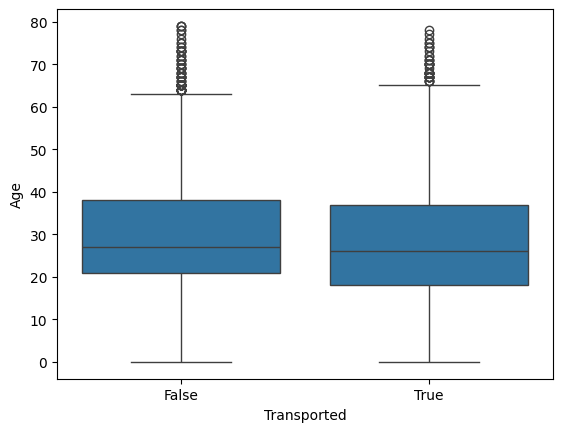

In [9]:
sns.boxplot(data= df_in_use, y = 'Age', x = 'Transported')


<Axes: xlabel='VIP', ylabel='Age'>

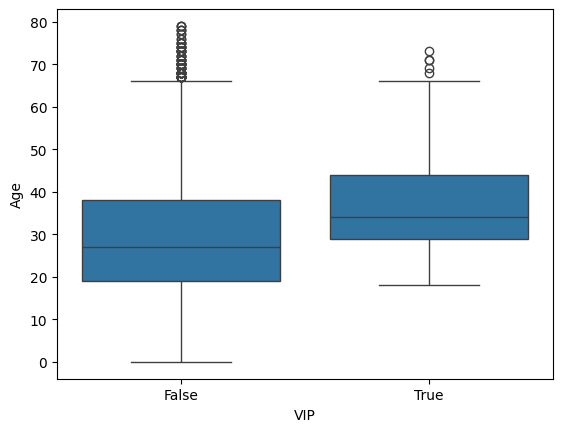

In [10]:
sns.boxplot(data= df_in_use, y = 'Age', x = 'VIP')

In [11]:
# dropper na verdier
def category_checkout(cat, df_in_use = df_in_use):
    return df_in_use.groupby(cat, dropna= False).agg({'PassengerId':'nunique', 'Transported':'mean'}).rename(columns = {'PassengerId': 'number_of_passengers', 'Transported': 'transport_rate'})

In [12]:
category_checkout('CryoSleep')

,number_of_passengers,transport_rate
CryoSleep,,
False,5439,0.328921
True,3037,0.817583
NaN,217,0.488479


In [13]:
category_checkout('VIP')

,number_of_passengers,transport_rate
VIP,,
False,8291,0.506332
True,199,0.381910
NaN,203,0.512315


In [14]:
df_in_use.VIP.fillna(False, inplace= True)

C:\Users\vetle\AppData\Local\Temp\ipykernel_2552\819172305.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_in_use.VIP.fillna(False, inplace= True)
C:\Users\vetle\AppData\Local\Temp\ipykernel_2552\819172305.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_in_use.VIP.fillna(False, inplace= True)


In [15]:
cat_cols = df_in_use.select_dtypes('object').columns
num_cols = df_in_use.select_dtypes('float64').columns

In [16]:
category_checkout('HomePlanet')

,number_of_passengers,transport_rate
HomePlanet,,
Earth,4602,0.423946
Europa,2131,0.658846
Mars,1759,0.523024
NaN,201,0.512438


In [17]:

df_in_use.HomePlanet = df_in_use.HomePlanet.fillna('Mars')

In [18]:
cat_cols

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination',
       'Name', 'Deck', 'Side'],
      dtype='object')

In [19]:
category_checkout('Destination')

,number_of_passengers,transport_rate
Destination,,
55 Cancri e,1800,0.610000
PSO J318.5-22,796,0.503769
TRAPPIST-1e,5915,0.471175
NaN,182,0.505495


In [20]:
df_in_use.Destination = df_in_use.Destination.fillna('PSO J318.5-22')

In [21]:
category_checkout('Deck')

,number_of_passengers,transport_rate
Deck,,
A,256,0.496094
B,779,0.734275
C,747,0.680054
D,478,0.433054
E,876,0.357306
F,2794,0.439871
G,2559,0.516217
T,5,0.200000
NaN,199,0.502513


In [22]:
category_checkout('Num').head(15)

,number_of_passengers,transport_rate
Num,,
0.0,18,0.333333
1.0,15,0.666667
2.0,11,0.454545
3.0,16,0.687500
4.0,7,0.285714
5.0,13,0.538462
6.0,12,0.333333
7.0,9,0.666667
8.0,13,0.461538


In [23]:
category_checkout('Side')

,number_of_passengers,transport_rate
Side,,
P,4206,0.451260
S,4288,0.555037
NaN,199,0.502513


In [24]:
df_in_use = df_in_use[df_in_use.Side.isna() == False]

In [25]:
df_in_use.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerInternalGroupNumber,Deck,Num,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1.0,1.0,B,0.0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,2.0,1.0,F,0.0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,3.0,1.0,A,0.0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,3.0,2.0,A,0.0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,4.0,1.0,F,1.0,S


In [26]:
df_in_use[df_in_use['Num'] == 'S']

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerGroup,PassengerInternalGroupNumber,Deck,Num,Side


In [27]:
cat_cols

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination',
       'Name', 'Deck', 'Side'],
      dtype='object')

In [28]:
df_in_use.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerInternalGroupNumber,Num
count,8319.000000,8317.000000,8316.000000,8288.000000,8313.000000,8310.000000,8494.000000,8494.000000,8494.000000
mean,28.820411,221.954671,457.992665,174.700531,306.623120,306.132371,4644.420768,1.516364,600.367671
std,14.488090,640.734593,1616.551099,608.668091,1119.076668,1148.895082,2668.389652,1.053900,511.867226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2347.000000,1.000000,167.250000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4643.500000,1.000000,427.000000
75%,38.000000,48.000000,78.250000,28.000000,59.000000,46.750000,6891.750000,2.000000,999.000000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,8.000000,1894.000000


In [29]:
def total_billed(df):
    df_out = df.copy()
    billing = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for i in billing:
        df_out[i] = df[i].fillna(0)
    df_out['TotalBill'] = df_out.RoomService + df_out.FoodCourt + df_out.ShoppingMall + df_out.Spa + df_out.VRDeck
    df_out['SpentMoney'] = np.where(df_out['TotalBill'].values == 0, True, False)
    return df_out


df_in_use = total_billed(df_in_use)

## Models

In [30]:
df_in_use.drop(columns=['PassengerId', 'Cabin', 'Name'], inplace= True)

In [31]:
cat_cols = df_in_use.select_dtypes('object').columns
num_cols = df_in_use.select_dtypes('float64').columns

df_in_use = pd.get_dummies(df_in_use, columns=cat_cols)
df_in_use.shape

(8494, 31)

In [32]:
df_in_use.head()

,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerGroup,PassengerInternalGroupNumber,Num,TotalBill,SpentMoney,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S
0,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1.0,1.0,0.0,0.0,True,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False
1,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2.0,1.0,0.0,736.0,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True
2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3.0,1.0,0.0,10383.0,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True
3,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3.0,2.0,0.0,5176.0,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True
4,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4.0,1.0,1.0,1091.0,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True


In [33]:
df_in_use.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerInternalGroupNumber,Num,TotalBill
count,8319.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000,8494.000000
mean,28.820411,217.329527,448.394985,170.463621,300.089239,299.500824,4644.420768,1.516364,600.367671,1435.778196
std,14.488090,634.815061,1600.866060,601.841469,1107.973046,1137.255247,2668.389652,1.053900,511.867226,2789.321730
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2347.000000,1.000000,167.250000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4643.500000,1.000000,427.000000,717.000000
75%,38.000000,41.750000,61.750000,23.000000,53.000000,40.000000,6891.750000,2.000000,999.000000,1438.750000
max,79.000000,9920.000000,29813.000000,23492.000000,22408.000000,24133.000000,9280.000000,8.000000,1894.000000,35987.000000


In [34]:
from sklearn.preprocessing import StandardScaler

numeric_df = df_in_use[num_cols]
df_in_use = df_in_use.drop(columns = num_cols)



In [35]:
scaler = StandardScaler()

numeric_df = scaler.fit_transform(numeric_df)
numeric_df = pd.DataFrame(numeric_df, columns=num_cols)

df_in_use = pd.merge(df_in_use, numeric_df, right_index= True, left_index= True)
df_in_use.head()

,VIP,Transported,SpentMoney,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerInternalGroupNumber,Num,TotalBill
0,False,False,True,False,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,0.702660,-0.342371,-0.280112,-0.283253,-0.270861,-0.263370,-1.740261,-0.489985,-1.172966,-0.514771
1,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,-0.332735,-0.170657,-0.274489,-0.241712,0.224667,-0.224678,-1.739886,-0.489985,-1.172966,-0.250892
2,True,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,2.014161,-0.274631,1.953811,-0.283253,5.790112,-0.220281,-1.739511,-0.489985,-1.172966,3.207858
3,False,False,False,False,True,False,True,False,False,False,True,True,False,False,False,False,False,False,False,False,True,0.288502,-0.342371,0.521377,0.333224,2.733901,-0.093653,-1.739511,0.458928,-1.172966,1.340986
4,False,True,False,True,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,-0.884946,0.134961,-0.236383,-0.032342,0.239109,-0.261611,-1.739137,-0.489985,-1.171013,-0.123614


In [36]:
df_in_use = df_in_use.dropna()

In [37]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [38]:
from sklearn.model_selection import train_test_split
X = df_in_use.drop(columns= ['Transported'], axis = 1)
Y = df_in_use['Transported']
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [39]:
def naive_bayes(x_train, y_train):
    print(f'Naive bayes:')
    classifier = GaussianNB()
    classifier.fit(x_train, y_train)
    return classifier

# support vector classifier
def svm_classifier(x_train, y_train):
    print(f'\n\nSupport vector classifier:')
    classifier = SVC(kernel= 'rbf', gamma= 'scale')
    classifier.fit(x_train, y_train)
    return classifier

def knn_classifier(x_train, y_train):
    print(f'\n\nK nearest neighbors:')
    classifier = KNeighborsClassifier(n_neighbors= 675)
    classifier.fit(x_train, y_train)
    return classifier

def logistic_classifier(x_train, y_train):
    print(f'\n\nlogistic regression:')
    classifier = LogisticRegression(solver= 'liblinear')
    classifier.fit(x_train, y_train)
    return classifier

def decision_tree_classifier(x_train, y_train):
    print(f'\n\nDecision tree:')
    classifier = DecisionTreeClassifier(max_depth=6)
    classifier.fit(x_train, y_train)
    return classifier

def random_forest_classifier(x_train, y_train, n_estimators=50):
    print(f'\n\nRandom forest:')
    classifier = RandomForestClassifier(n_estimators=n_estimators)
    classifier.fit(x_train, y_train)
    return classifier

In [40]:
from sklearn.metrics import accuracy_score


def build_and_train_classifier(classification_fn,x_train = x_train, y_train = y_train):
    model = classification_fn(x_train, y_train)
    y_pred = model.predict(x_test)

    train_score = model.score(x_train, y_train)
    test_score = accuracy = accuracy_score(y_test,y_pred)

    print("Training score : ", train_score)
    print("Test score : ", test_score)

In [41]:
build_and_train_classifier(naive_bayes)
build_and_train_classifier(svm_classifier)
build_and_train_classifier(decision_tree_classifier)
build_and_train_classifier(random_forest_classifier)
build_and_train_classifier(knn_classifier)
build_and_train_classifier(logistic_classifier)

Naive bayes:
Training score :  0.7106802092951677
Test score :  0.7267692307692307


Support vector classifier:
Training score :  0.7483841181902123
Test score :  0.7532307692307693


Decision tree:
Training score :  0.7646968297937827
Test score :  0.7378461538461538


Random forest:
Training score :  0.9996922129886119
Test score :  0.7563076923076923


K nearest neighbors:


c:\Users\vetle\repo\space-titanic-kaggle\venv\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\vetle\repo\space-titanic-kaggle\venv\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Training score :  0.7246845183133271
Test score :  0.7427692307692307


logistic regression:
Training score :  0.7382271468144044
Test score :  0.7532307692307693


In [42]:
build_and_train_classifier(naive_bayes)
build_and_train_classifier(svm_classifier)
build_and_train_classifier(decision_tree_classifier)
build_and_train_classifier(random_forest_classifier)
build_and_train_classifier(knn_classifier)
build_and_train_classifier(logistic_classifier)

Naive bayes:
Training score :  0.7106802092951677
Test score :  0.7267692307692307


Support vector classifier:
Training score :  0.7483841181902123
Test score :  0.7532307692307693


Decision tree:
Training score :  0.7643890427823946
Test score :  0.7384615384615385


Random forest:
Training score :  0.9993844259772238
Test score :  0.7501538461538462


K nearest neighbors:
Training score :  0.7246845183133271
Test score :  0.7427692307692307


logistic regression:
Training score :  0.7382271468144044
Test score :  0.7532307692307693


In [43]:
my_model = build_and_train_classifier(knn_classifier)



K nearest neighbors:
Training score :  0.7246845183133271
Test score :  0.7427692307692307


In [44]:
# Set up pipeline
def passenger_group(df):
    df_out = df.copy()
    df_out['PassengerGroup'] = df_out.PassengerId.str.split('_').str[0].astype(float)
    df_out['PassengerInternalGroupNumber'] = df_out.PassengerId.str.split('_').str[1].astype(float)
    df_out.drop(columns = ['PassengerId', 'Name'])
    return df_out

def cabin_split(df):
    df_out = df.copy()
    df_out = df_out[df_out.Cabin.isna() == False]
    df_out['Deck'] = df_out.Cabin.str.split('/').str[0]
    df_out['Num'] = df_out.Cabin.str.split('/').str[1].astype(float)
    df_out['Side'] = df_out.Cabin.str.split('/').str[2]
    return df_out

def total_billed(df):
    df_out = df.copy()
    billing = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for i in billing:
        df_out[i] = df[i].fillna(0)
    df_out['TotalBill'] = df_out.RoomService + df_out.FoodCourt + df_out.ShoppingMall + df_out.Spa + df_out.VRDeck
    df_out['SpentMoney'] = np.where(df_out['TotalBill'].values == 0, True, False)
    return df_out


In [56]:
test_data = pd.read_csv('test.csv')

test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [46]:
x_train.head()

,VIP,SpentMoney,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_False,CryoSleep_True,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,PassengerGroup,PassengerInternalGroupNumber,Num,TotalBill
7782,False,True,False,True,False,False,True,False,False,True,True,False,False,False,False,False,False,False,False,True,1.530976,1.028187,-0.262620,0.178689,-0.131860,0.869248,1.450241,-0.489985,2.242183,0.423863
8085,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,-0.332735,-0.337645,1.537761,-0.283253,-0.169770,-0.231713,1.573168,-0.489985,-0.651316,0.582693
835,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,True,0.840713,-0.342371,-0.280112,-0.283253,-0.270861,-0.263370,-1.393964,1.407840,-0.799801,-0.514771
2041,False,True,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,True,1.185844,-0.342371,-0.280112,-0.283253,-0.270861,-0.263370,-0.894383,-0.489985,-0.461803,-0.514771
7816,False,False,False,True,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,0.012396,-0.342371,-0.280112,-0.283253,-0.270861,-0.263370,1.467855,-0.489985,1.513435,-0.514771


In [47]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Custom transformer for passenger_group function
class PassengerGroupTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df_out = X.copy()
        df_out['PassengerGroup'] = df_out.PassengerId.str.split('_').str[0].astype(float)
        df_out['PassengerInternalGroupNumber'] = df_out.PassengerId.str.split('_').str[1].astype(float)
        df_out = df_out.drop(columns=['PassengerId', 'Name'])
        #print("Passenger Group completed")
        return df_out

# Custom transformer for cabin_split function
class CabinSplitTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df_out = X.copy()
        #df_out = df_out[df_out.Cabin.notna()]
        df_out['Deck'] = df_out.Cabin.str.split('/').str[0]
        df_out['Num'] = df_out.Cabin.str.split('/').str[1].astype(float)
        df_out['Side'] = df_out.Cabin.str.split('/').str[2]
        df_out = df_out.drop(columns=['Cabin'])
        if (df_out.Num=='S').sum() > 0: print("Num")
        #print("Cabin completed")
        return df_out

# Custom transformer for total_billed function
class TotalBilledTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df_out = X.copy()
        billing = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
        for i in billing:
            df_out[i] = df_out[i].fillna(0)
        df_out['TotalBill'] = df_out.RoomService + df_out.FoodCourt + df_out.ShoppingMall + df_out.Spa + df_out.VRDeck
        df_out['SpentMoney'] = np.where(df_out['TotalBill'].values == 0, False, True)
        #print("Total bill completed")
        return df_out
    

class NANTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        df_out = X.copy()
        df_out['VIP'] = df_out['VIP'].astype(bool).fillna(False)
        #df_out['VIP'] = df_out['VIP']
        df_out.Destination = df_out.Destination.fillna('PSO J318.5-22')
        df_out.HomePlanet = df_out.HomePlanet.fillna('Mars')
        df_out.CryoSleep = df_out.CryoSleep.fillna('N')
        df_out.CryoSleep = df_out.CryoSleep.astype(str)        
        df_out.Deck = df_out.Deck.fillna('G')
        df_out.Side = df_out.Side.fillna('M')
        df_out.Age = df_out.Age.fillna(df_out.Age.median())
        df_out.Num = df_out.Num.fillna(df_out.Num.median())
        #print("Nan transforms completed")
        return df_out
# Define the pipeline
    

    # Define column transformer
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
        ('num', StandardScaler(), num_cols)  # You need to define num_cols
    ])

# Updated pipeline definition
dp_pipeline = Pipeline(steps=[
    ('passenger_group', PassengerGroupTransformer()),
    ('cabin_split', CabinSplitTransformer()),
    ('total_billed', TotalBilledTransformer()),
    ('vip', NANTransformer()),
    ('preprocess', preprocess)  # Include both encoding and scaling in this step
])

# Note: Since pd.get_dummies was used before the pipeline, we directly apply standard scaling in the pipeline.
# If you want to include a model, add it as the last step in the pipeline.


In [49]:
gaussian_pipeline = Pipeline([
                                ('preprocessing', dp_pipeline),  # This is your existing preprocessing pipeline
                                ('classifier', GaussianNB())
                            ])
X = df.drop(columns= ['Transported'], axis = 1)
Y = df['Transported']
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
#print(cat_cols)
gaussian_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('passenger_group',
                                  PassengerGroupTransformer()),
                                 ('cabin_split', CabinSplitTransformer()),
                                 ('total_billed', TotalBilledTransformer()),
                                 ('vip', NANTransformer()),
                                 ('preprocess',
                                  ColumnTransformer(transformers=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   Index(['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side'], dtype='object')),
                                                                  ('num',
                                                                   StandardScaler(),
                                                                   Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'PassengerGroup', 'PassengerInternalGroupNumber', 'Num', 'TotalBill'],
      dtype='object'))]))])),
                ('classifier', GaussianNB())])

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

open_classifier_pipeline = Pipeline([
                                ('preprocessing', dp_pipeline),  # This is your existing preprocessing pipeline
                                ('classifier', None)
                            ])

param_grid = [
    # Naive Bayes (no hyperparameters to tune for the basic GaussianNB)
    {'classifier': [GaussianNB()]},
    
    # K-Nearest Neighbors
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': [3, 5, 7, 20]},
    
    # Support Vector Machine
    {'classifier': [SVC()],
     'classifier__kernel': ['rbf', 'linear'],
     'classifier__gamma': ['scale', 'auto']},
    
    # Logistic Regression
    {'classifier': [LogisticRegression()],
     'classifier__solver': ['liblinear'],
     'classifier__penalty': ['l1', 'l2'],
     'classifier__C': [0.01, 0.1, 1, 10, 100]},


     # Logistic Regression 2
    {'classifier': [LogisticRegression()],
     'classifier__solver': ['lbfgs'],
     #'classifier__penalty': ['l1', 'l2'],
     'classifier__C': [0.01, 0.1, 1, 10, 100]},
    
    # Decision Tree
    {'classifier': [DecisionTreeClassifier()],
     'classifier__max_depth': [3, 6, None]},
    
    # Random Forest
    {'classifier': [RandomForestClassifier()],
     'classifier__n_estimators': [10, 50, 100],
     'classifier__max_depth': [3, 6, None]},

      # XGBoost parameters
    {'classifier': [XGBClassifier()],
     'classifier__n_estimators': [75,100, 125],
     'classifier__learning_rate': [0.18,0.19,0.195],
     'classifier__max_depth': [3, 4],
     'classifier__subsample': [0.8, 1],
     'classifier__colsample_bytree': [0.8, 1]}
]

# Make sure your pipeline variable is defined and includes a 'classifier' step
# pipeline = Pipeline([...])

grid_search = GridSearchCV(open_classifier_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# After fitting, you can inspect the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'classifier__colsample_bytree': 1, 'classifier__learning_rate': 0.19, 'classifier__max_depth': 4, 'classifier__n_estimators': 100, 'classifier__subsample': 1}
Best score: 0.8109003925543965


In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


open_classifier_pipeline = Pipeline([
                                ('preprocessing', dp_pipeline),  # This is your existing preprocessing pipeline
                                ('classifier', None)
                            ])

param_grid = [
    # Naive Bayes (no hyperparameters to tune for the basic GaussianNB)
    {'classifier': [GaussianNB()]},
    
    # K-Nearest Neighbors
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': [3, 5, 7, 20]},
    
    # Support Vector Machine
    {'classifier': [SVC()],
     'classifier__kernel': ['rbf', 'linear'],
     'classifier__gamma': ['scale', 'auto']},
    
    # Logistic Regression
    {'classifier': [LogisticRegression()],
     'classifier__solver': ['liblinear'],
     'classifier__penalty': ['l1', 'l2'],
     'classifier__C': [0.01, 0.1, 1, 10, 100, 100000]},


     # Logistic Regression 2
    {'classifier': [LogisticRegression()],
     'classifier__solver': ['lbfgs'],
     #'classifier__penalty': ['l1', 'l2'],
     'classifier__C': [0.01, 0.1, 1, 10, 100]},
    
    # Decision Tree
    {'classifier': [DecisionTreeClassifier()],
     'classifier__max_depth': [3, 6,100,1000000, None]},
    
    # Random Forest
    {'classifier': [RandomForestClassifier()],
     'classifier__n_estimators': [10, 50, 100],
     'classifier__max_depth': [3, 6, None]}

   
]

# Make sure your pipeline variable is defined and includes a 'classifier' step
# pipeline = Pipeline([...])

grid_search = GridSearchCV(open_classifier_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

# After fitting, you can inspect the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'classifier': SVC(), 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'}
Best score: 0.8034232398409094


In [81]:
np.linspace(75,125, 9)

array([ 75.  ,  81.25,  87.5 ,  93.75, 100.  , 106.25, 112.5 , 118.75,
       125.  ])

In [92]:
open_classifier_pipeline = Pipeline([
                                ('preprocessing', dp_pipeline),  # This is your existing preprocessing pipeline
                                ('classifier', None)
                            ])


param_grid = [
    {
        'classifier': [XGBClassifier()],
        'classifier__n_estimators': np.linspace(75, 125, 19, dtype=int).tolist(),  # Generates 5 values from 75 to 125
        'classifier__learning_rate': np.linspace(0.18, 0.2).tolist(),  # Generates 3 values from 0.18 to 0.2
        'classifier__max_depth': [3, 4],
        'classifier__subsample': [0.8, 1],
        'classifier__colsample_bytree': [0.8, 1]
    }
]

# Assuming 'open_classifier_pipeline' is your pipeline and is correctly defined
grid_search = GridSearchCV(open_classifier_pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)


Best parameters: {'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...), 'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.1926530612244898, 'classifier__max_depth': 4, 'classifier__n_estimators': 91, 'classifier__subsample': 1}
Best score: 0.8113308059519315


In [ ]:
gaussian_pipeline = Pipeline([
                                ('preprocessing', dp_pipeline),  # This is your existing preprocessing pipeline
                                ('classifier', GaussianNB()) #classifier': SVC(), 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf'
                            ])
X = df.drop(columns= ['Transported'], axis = 1)
Y = df['Transported']
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
#print(cat_cols)
gaussian_pipeline.fit(x_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('passenger_group',
                                  PassengerGroupTransformer()),
                                 ('cabin_split', CabinSplitTransformer()),
                                 ('total_billed', TotalBilledTransformer()),
                                 ('vip', NANTransformer()),
                                 ('preprocess',
                                  ColumnTransformer(transformers=[('cat',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   Index(['HomePlanet', 'CryoSleep', 'Destination', 'Deck', 'Side'], dtype='object')),
                                                                  ('num',
                                                                   StandardScaler(),
                                                                   Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'PassengerGroup', 'PassengerInternalGroupNumber', 'Num', 'TotalBill'],
      dtype='object'))]))])),
                ('classifier', GaussianNB())])

In [52]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(gaussian_pipeline, x_test, y_test, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.75 (+/- 0.05)


In [ ]:
scores = cross_val_score(gaussian_pipeline, x_test, y_test, cv=5, scoring='precision')
print("Precision: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Precision: 0.70 (+/- 0.06)


In [93]:
# Assuming 'grid_search' is your GridSearchCV object that included the entire pipeline
best_pipeline = grid_search.best_estimator_
scores = cross_val_score(best_pipeline, x_test, y_test, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.02)


In [ ]:
#from sklearn.svm import SVC

# Assuming 'pipeline' is your original pipeline without the final classifier step
top = open_classifier_pipeline.set_params(classifier=SVC(gamma='scale', kernel='rbf'))

top.fit(x_train, y_train)
scores = cross_val_score(top, x_test, y_test, cv=5, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


Accuracy: 0.79 (+/- 0.03)


In [ ]:
test_data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [ ]:
y_pred = top.predict(test_data)
test_ut = pd.DataFrame({'PassengerId': test_data.PassengerId.values,'Transported': y_pred })
test_ut.to_csv('first_submission.csv', index = False)

In [94]:
y_pred = best_pipeline.predict(test_data)
test_ut = pd.DataFrame({'PassengerId': test_data.PassengerId.values,'Transported': y_pred })
test_ut.Transported = np.where(test_ut.Transported == 1, True, False)
test_ut.to_csv('final_xg_submission.csv', index = False)

In [68]:
y_pred

array([1, 0, 1, ..., 1, 1, 1])

In [60]:
test_ut.Transported = np.where(test_ut.Transported == 1, True, False)

In [64]:
test_ut.to_csv('third_submission.csv', index = False)

In [63]:
test_ut

,PassengerId,Transported
0,0013_01,0
1,0018_01,1
2,0019_01,0
3,0021_01,0
4,0023_01,0
...,...,...
4272,9266_02,0
4273,9269_01,0
4274,9271_01,0
4275,9273_01,0


In [67]:
first = pd.read_csv('first_submission.csv')


print(first.shape)
first.head()


(4277, 2)


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False


# Next step - a neural net

**XGBoost Captures complex relationships. A neural net might be able to do that better**


In [66]:
pd.read_csv('third_submission.csv').shape

(4277, 2)

In [90]:
from sklearn.base import BaseEstimator, ClassifierMixin
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_shape, num_classes, epochs=100, batch_size=32):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = self._build_model()
    
    def _build_model(self):
        model = Sequential([
            Dense(64, activation='relu', input_shape=(self.input_shape,)),
            Dense(64, activation='relu'),
            Dense(self.num_classes, activation='softmax')
        ])
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return model
    
    def fit(self, X, y):
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self
    
    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions.argmax(axis=1)
    
    def score(self, X, y):
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
        return accuracy


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [91]:
import tensorflow as tf
import sklearn
import xgboost as xgb
import numpy as np
import pandas as pd

print(f"TensorFlow Version: {tf.__version__}")
print(f"scikit-learn Version: {sklearn.__version__}")
print(f"XGBoost Version: {xgb.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")


TensorFlow Version: 2.15.0
scikit-learn Version: 1.4.0
XGBoost Version: 2.0.3
NumPy Version: 1.26.3
Pandas Version: 2.2.0
